## Question 3: Data Pipeline and Transformation

In [1]:
# Import Python packages
import math
import os
import random
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from datetime import date, datetime
import functools
import logging

Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021.

In [2]:
data_file = "../data/MarketData.csv"
try:
    # Read in data set from the csv file, skip initial metadata rows (first 3 rows)
    f = open(data_file, 'rb')
    df = pd.read_csv(f, skiprows = 3, header = [0, 1, 2, 3])

    # Drop the first column name from the multi-index (for "Dates" column)
    df.columns = ['Dates'] + [f"{col[0]} ({col[1]})" for col in df.columns[1:]]
    
except:
    print('Error opening file/loading data')

In [3]:
# Convert "Dates" column to datetime format, European date format
df["Dates"] = pd.to_datetime(df["Dates"], dayfirst=True)

# Display the first few rows
df

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
0,2010-01-01,7375.0,2230.0,2560.0,2432.0,16950,79.36
1,2010-01-04,7500.0,2267.0,2574.0,2515.0,17450,81.51
2,2010-01-05,7485.0,2302.0,2575.0,2522.5,17375,81.77
3,2010-01-06,7660.0,2377.0,2718.0,2680.0,17825,83.18
4,2010-01-07,7535.0,2310.0,2607.0,2599.0,17475,82.66
...,...,...,...,...,...,...,...
3386,2022-12-26,8349.5,2389.5,2965.0,2273.5,23934,79.56
3387,2022-12-27,8349.5,2389.5,2965.0,2273.5,23934,79.53
3388,2022-12-28,8443.0,2381.0,3005.5,2218.0,24734,78.96
3389,2022-12-29,8418.0,2405.0,2984.5,2272.5,24915,78.40


In [4]:
# First slice dataframe by "Dates", copper and zinc columns, then slice by the 2020 and 2021 data
copper_zinc = ['Dates', 'LME COPPER    3MO ($) (LMCADS03 Comdty)', 'LME ZINC      3MO ($) (LMZSDS03 Comdty)']
df_filtered = df[copper_zinc][df['Dates'].dt.year.isin([2020, 2021])]
df_filtered.set_index('Dates', inplace=True)
df_filtered

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty)
Dates,,
2020-01-01,6174.0,2272.0
2020-01-02,6188.0,2310.0
2020-01-03,6129.5,2306.0
2020-01-06,6138.5,2324.5
2020-01-07,6149.0,2346.0
...,...,...
2021-12-27,9568.0,3519.0
2021-12-28,9568.0,3519.0
2021-12-29,9680.5,3513.0


In [5]:
# Match column names to simple commodity names and colours
commodity_mapping = {
    'LME COPPER    3MO ($) (LMCADS03 Comdty)': ('Copper', 'orange'),
    'LME ZINC      3MO ($) (LMZSDS03 Comdty)': ('Zinc', 'green')
}
commodity_mapping

{'LME COPPER    3MO ($) (LMCADS03 Comdty)': ('Copper', 'orange'),
 'LME ZINC      3MO ($) (LMZSDS03 Comdty)': ('Zinc', 'green')}

Calculate MACD (slow/medium/fast) and RSI for each metal historically using the following parameters for the slow, fast and signal windows: 26, 12, 9 for the MACD model and an RSI period of 14.

First start with MACD

In [6]:
# Define function for MACD calculation using the Exponential Moving Average (EMA) built-in python method
# Calculate the fast EMA (e.g. 12-period), slow EMA (e.g 26-period), and signal line (9-period)
# MACD line is the difference between the fast and slow EMA lines
# The signal line is the X-period MACD line (typically X=9)
# The MACD histogram is the difference between the MACD line and signal signal

def macd(df, fast_window=12, slow_window=26, signal_window=9):

    df_fast_ema = df.ewm(span=fast_window, adjust=False).mean()  # Fast EMA (e.g. 12)
    df_slow_ema = df.ewm(span=slow_window, adjust=False).mean()  # Slow EMA (e.g. 26)
    df_macd_line = df_fast_ema - df_slow_ema  # MACD line (Fast - Slow)
    df_signal_line = df_macd_line.ewm(span=signal_window, adjust=False).mean()  # Signal Line (e.g. 9)
    df_macd_histogram = df_macd_line - df_signal_line # MACD Histogram

    return df_macd_line, df_signal_line, df_macd_histogram

In [7]:
# Define windows for fast and slow EMA and window for the signal line  
fast_window=12
slow_window=26
signal_window=9

df_macd_line, df_signal_line, df_macd_histogram = macd(df_filtered, fast_window, slow_window, signal_window)

# Display the DataFrame with MACD line
df_macd_line

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty)
Dates,,
2020-01-01,0.000000,0.000000
2020-01-02,1.116809,3.031339
2020-01-03,-2.687592,5.052686
2020-01-06,-4.919671,8.054566
2020-01-07,-5.774780,12.029776
...,...,...
2021-12-27,-2.500190,66.849430
2021-12-28,0.815513,69.361656
2021-12-29,12.378352,70.060845


In [8]:
df_signal_line

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty)
Dates,,
2020-01-01,0.000000,0.000000
2020-01-02,0.223362,0.606268
2020-01-03,-0.358829,1.495551
2020-01-06,-1.270997,2.807354
2020-01-07,-2.171754,4.651839
...,...,...
2021-12-27,-20.259043,41.187284
2021-12-28,-16.044131,46.822159
2021-12-29,-10.359635,51.469896


In [9]:
df_macd_histogram

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty)
Dates,,
2020-01-01,0.000000,0.000000
2020-01-02,0.893447,2.425071
2020-01-03,-2.328763,3.557135
2020-01-06,-3.648674,5.247211
2020-01-07,-3.603026,7.377937
...,...,...
2021-12-27,17.758853,25.662145
2021-12-28,16.859645,22.539497
2021-12-29,22.737987,18.590949


Plot MACD with Signal line and MACD histogram under commodity price time series

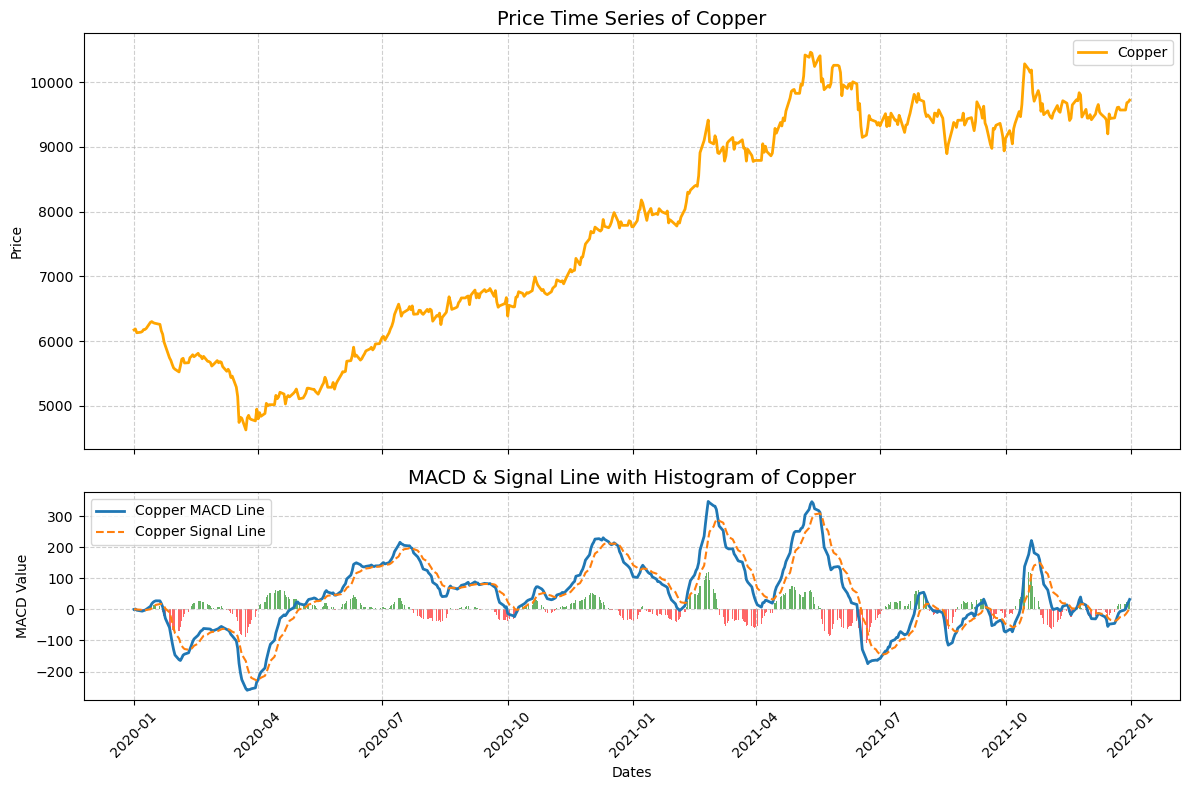

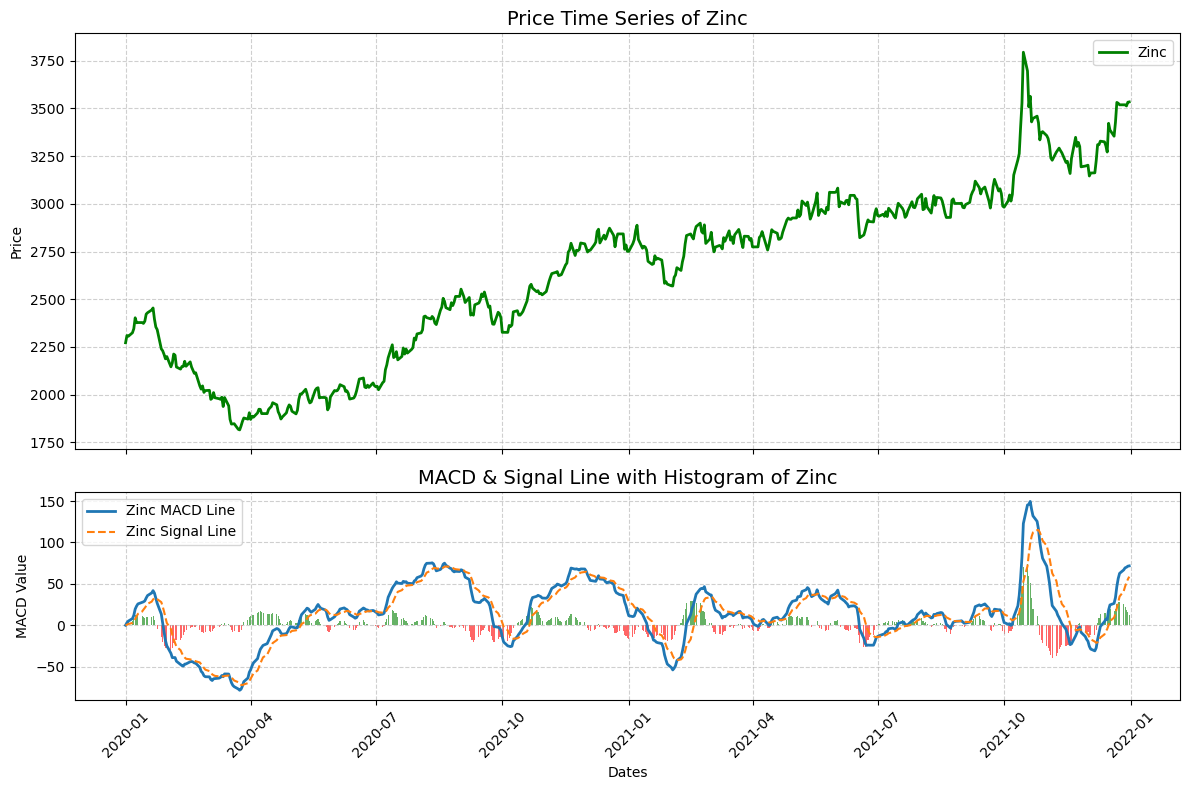

In [10]:
for comdty in copper_zinc[1:]:

    # Create figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    name, colour = commodity_mapping[comdty]

    # --- Price Time Series (Top) ---
    ax[0].plot(df_filtered.index, df_filtered[comdty], label=name, color=colour, linewidth=2)
    ax[0].set_title('Price Time Series of '+name, fontsize=14)
    ax[0].set_ylabel('Price')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.6)

    # --- MACD, Signal & Histogram (Bottom) ---
    ax[1].plot(df_filtered.index, df_macd_line[comdty], linewidth=2, label=name+' MACD Line')
    ax[1].plot(df_filtered.index, df_signal_line[comdty], linewidth=1.5, linestyle='dashed', label=name+' Signal Line')

    # Histogram bars
    ax[1].bar(df_filtered.index, df_macd_histogram[comdty], color=['green' if v >= 0 else 'red' for v in df_macd_histogram[comdty]], width=0.8, alpha=0.6)

    ax[1].set_title('MACD & Signal Line with Histogram of '+name, fontsize=14)
    ax[1].set_ylabel('MACD Value')
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # Format x-axis
    plt.xlabel('Dates')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.savefig('time_series_macd_'+name+'_filtered.pdf')
    plt.show()

Calculate the Relative Strength Index (RSI) line for the two commodities

In [11]:
def rsi(df, period=14):

    # Step 1 of RSI calculation: use simple moving average (SMA) for the first period
    # Calculate daily price changes
    df_price_change = df.diff()

    # Separate gains and losses
    df_gains = df_price_change.where(df_price_change > 0, 0)
    df_losses = -df_price_change.where(df_price_change < 0, 0)

    # Compute initial average gain/loss (first 14 values using SMA)
    df_avg_gain = df_gains.rolling(window=period, min_periods=period).mean()
    df_avg_loss = df_losses.rolling(window=period, min_periods=period).mean()

    # # Step 2: Calculate the smoothed averages for RSI
    for i in range(period, len(df)):
        df_avg_gain.iloc[i] = ((df_avg_gain.iloc[i - 1] * (period - 1)) + df_gains.iloc[i]) / period
        df_avg_loss.iloc[i] = ((df_avg_loss.iloc[i - 1] * (period - 1)) + df_losses.iloc[i]) / period

    # Calculate RS (Relative Strength)
    df_rs = df_avg_gain / df_avg_loss

    # Calculate RSI using the formula
    df_rsi = 100 - (100 / (1 + df_rs))

    return df_rsi

In [12]:
# Define the period for RSI metric e.g. 14  
rsi_period=14

df_rsi= rsi(df_filtered, rsi_period)

In [13]:
df_rsi

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty)
Dates,,
2020-01-01,NaN,NaN
2020-01-02,NaN,NaN
2020-01-03,NaN,NaN
2020-01-06,NaN,NaN
2020-01-07,NaN,NaN
...,...,...
2021-12-27,51.692406,66.260897
2021-12-28,51.692406,66.260897
2021-12-29,56.618811,65.418907


Plot RSI under the commodity price time series for each commodity

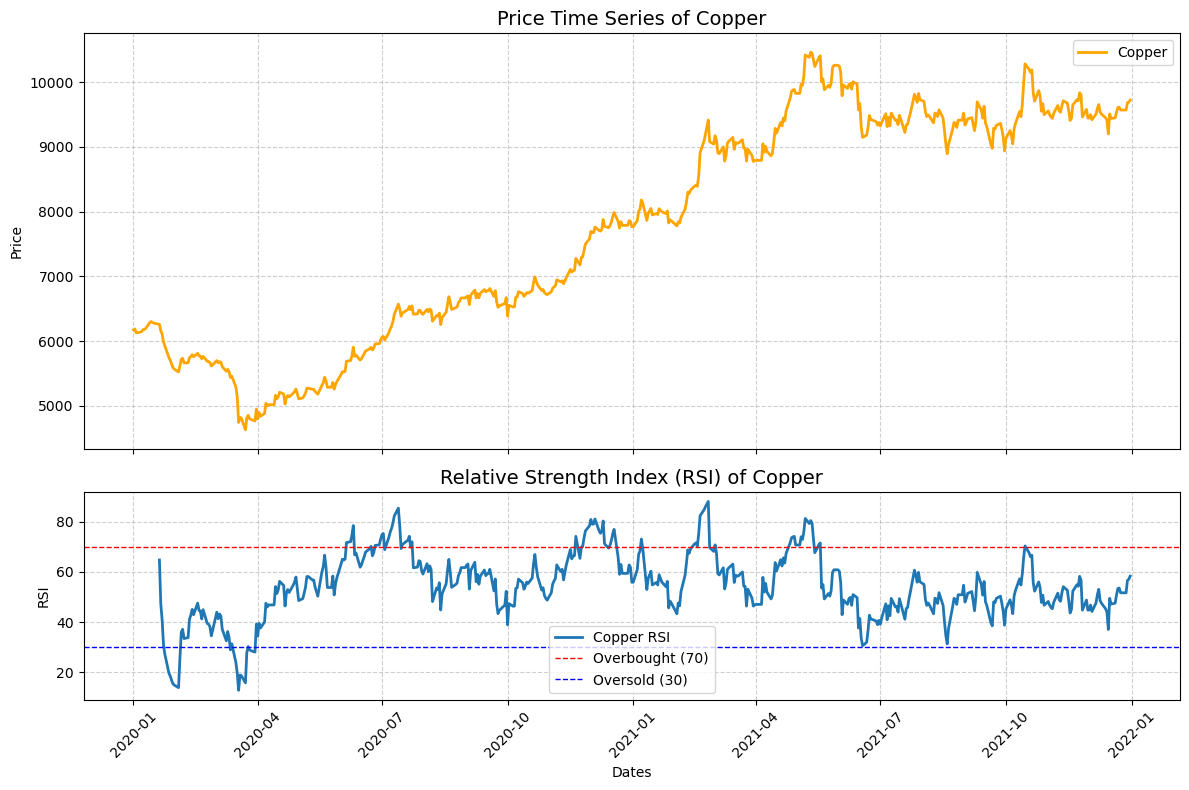

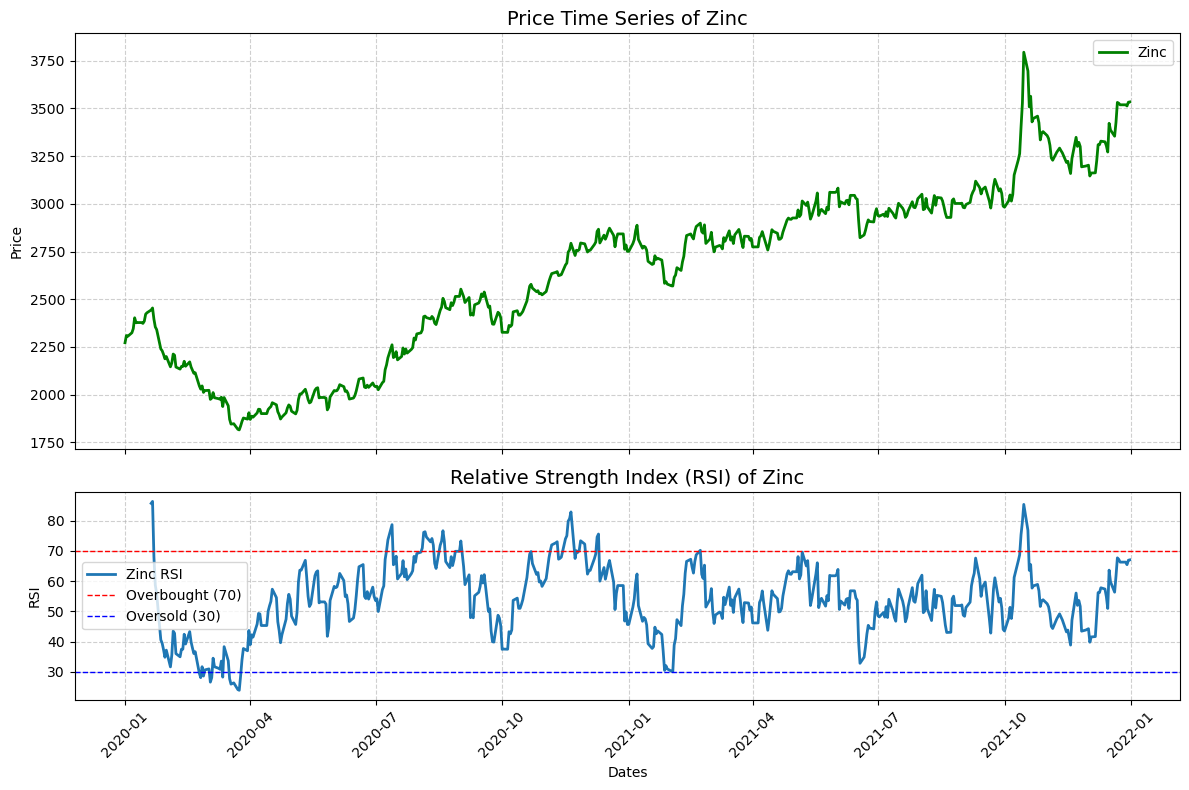

In [14]:
for comdty in copper_zinc[1:]:

    # Create figure and axes for subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    name, colour = commodity_mapping[comdty]

    # --- Plot Price Time Series (Top) ---
    ax[0].plot(df_filtered.index, df_filtered[comdty], label=name, color=colour, linewidth=2)
    ax[0].set_title('Price Time Series of '+name, fontsize=14)
    ax[0].set_ylabel('Price')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.6)

    # --- Plot RSI (Bottom) ---
    ax[1].plot(df_filtered.index, df_rsi[comdty], linewidth=2, label=name+' RSI')
    ax[1].axhline(70, color='red', linestyle='dashed', linewidth=1, label='Overbought (70)')
    ax[1].axhline(30, color='blue', linestyle='dashed', linewidth=1, label='Oversold (30)')
    ax[1].set_title('Relative Strength Index (RSI) of '+name, fontsize=14)
    ax[1].set_ylabel('RSI')
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # Format x-axis
    plt.xlabel('Dates')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.savefig('time_series_rsi_'+name+'_filtered.pdf')
    plt.show()

Use SQL inserts to populate the SQL table created in Question 2 with this generated data. 

In [15]:
# Import sqlalchemy packages
from sqlalchemy import create_engine, inspect, Column, Integer, String, Float, DateTime
from sqlalchemy.orm import declarative_base, sessionmaker
from sqlalchemy import text

In [16]:
# Define the database URI
engine = create_engine('sqlite:///metal_prices.db')

In [17]:
# Define ORM model to easily access the data
Base = declarative_base()

class MetalPrice(Base):
    __tablename__ = 'metal_prices'

    Dates = Column(DateTime, primary_key=True)
    Metal = Column(String, primary_key=True)
    Price = Column(Float)
    MACD_line = Column(Float)
    Signal_line = Column(Float)
    MACD_histogram = Column(Float)
    RSI = Column(Float)

Base.metadata.create_all(engine)

In [18]:
with engine.connect() as conn:
    conn.execute(text('ALTER TABLE metal_prices ADD COLUMN MACD_line FLOAT'))
    conn.execute(text('ALTER TABLE metal_prices ADD COLUMN Signal_line FLOAT'))
    conn.execute(text('ALTER TABLE metal_prices ADD COLUMN MACD_histogram FLOAT'))
    conn.execute(text('ALTER TABLE metal_prices ADD COLUMN RSI FLOAT'))
    conn.commit()

In [19]:
# Use melt() to transform from wide to long format
df_long = df_filtered.reset_index().melt(id_vars=['Dates'], var_name='Metal', value_name='Price')
df_long

,Dates,Metal,Price
0,2020-01-01,LME COPPER 3MO ($) (LMCADS03 Comdty),6174.0
1,2020-01-02,LME COPPER 3MO ($) (LMCADS03 Comdty),6188.0
2,2020-01-03,LME COPPER 3MO ($) (LMCADS03 Comdty),6129.5
3,2020-01-06,LME COPPER 3MO ($) (LMCADS03 Comdty),6138.5
4,2020-01-07,LME COPPER 3MO ($) (LMCADS03 Comdty),6149.0
...,...,...,...
1041,2021-12-27,LME ZINC 3MO ($) (LMZSDS03 Comdty),3519.0
1042,2021-12-28,LME ZINC 3MO ($) (LMZSDS03 Comdty),3519.0
1043,2021-12-29,LME ZINC 3MO ($) (LMZSDS03 Comdty),3513.0
1044,2021-12-30,LME ZINC 3MO ($) (LMZSDS03 Comdty),3532.5


In [20]:
df_macd_line_long = df_macd_line.reset_index().melt(id_vars=['Dates'], var_name='Metal', value_name='MACD_line')
df_signal_line_long = df_signal_line.reset_index().melt(id_vars=['Dates'], var_name='Metal', value_name='Signal_line')
df_macd_histogram_long = df_macd_histogram.reset_index().melt(id_vars=['Dates'], var_name='Metal', value_name='MACD_histogram')
df_rsi_long = df_rsi.reset_index().melt(id_vars=['Dates'], var_name='Metal', value_name='RSI')

Merge the 5 dataframes on the 'Dates' and 'Metal' column.

In [21]:
df_merged = pd.merge(df_long, df_macd_line_long, on=['Dates', 'Metal'], how='inner')
df_merged = pd.merge(df_merged, df_signal_line_long, on=['Dates', 'Metal'], how='inner')
df_merged = pd.merge(df_merged, df_macd_histogram_long, on=['Dates', 'Metal'], how='inner')
df_merged = pd.merge(df_merged, df_rsi_long, on=['Dates', 'Metal'], how='inner')
df_merged


,Dates,Metal,Price,MACD_line,Signal_line,MACD_histogram,RSI
0,2020-01-01,LME COPPER 3MO ($) (LMCADS03 Comdty),6174.0,0.000000,0.000000,0.000000,NaN
1,2020-01-02,LME COPPER 3MO ($) (LMCADS03 Comdty),6188.0,1.116809,0.223362,0.893447,NaN
2,2020-01-03,LME COPPER 3MO ($) (LMCADS03 Comdty),6129.5,-2.687592,-0.358829,-2.328763,NaN
3,2020-01-06,LME COPPER 3MO ($) (LMCADS03 Comdty),6138.5,-4.919671,-1.270997,-3.648674,NaN
4,2020-01-07,LME COPPER 3MO ($) (LMCADS03 Comdty),6149.0,-5.774780,-2.171754,-3.603026,NaN
...,...,...,...,...,...,...,...
1041,2021-12-27,LME ZINC 3MO ($) (LMZSDS03 Comdty),3519.0,66.849430,41.187284,25.662145,66.260897
1042,2021-12-28,LME ZINC 3MO ($) (LMZSDS03 Comdty),3519.0,69.361656,46.822159,22.539497,66.260897
1043,2021-12-29,LME ZINC 3MO ($) (LMZSDS03 Comdty),3513.0,70.060845,51.469896,18.590949,65.418907
1044,2021-12-30,LME ZINC 3MO ($) (LMZSDS03 Comdty),3532.5,71.365785,55.449074,15.916711,66.891416


Use a decorator to log SQL inserts.

In [22]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

def log_db_insert(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        logging.info("Starting database insert operation...")
        result = func(*args, **kwargs)
        logging.info("Finished database insert operation.")
        return result
    return wrapper

Insert data into the database created earlier.

In [23]:
Session = sessionmaker(bind=engine)

In [24]:
with Session() as session:

    results = session.query(MetalPrice).all()

    # Print each row
    for row in results:
        print(f"Dates: {row.Dates}, Metal: {row.Metal}, Price: {row.Price}")

In [25]:
@log_db_insert
def insert_data_to_db(df):
    with Session() as session:
        for _, row in df.iterrows():
            obj = MetalPrice(
                Dates=pd.to_datetime(row['Dates']),
                Metal=row['Metal'],
                Price=row['Price'],
                MACD_line=row['MACD_line'],
                Signal_line=row['Signal_line'],
                MACD_histogram=row['MACD_histogram'],
                RSI=row['RSI']
            )
            session.merge(obj)  # Use merge to avoid duplicates if primary key exists
        session.commit()

In [26]:
insert_data_to_db(df_merged)

2025-04-06 23:39:17,544 - Starting database insert operation...
2025-04-06 23:39:19,904 - Finished database insert operation.


Print first 10 rows of the newly created table.

In [40]:
with Session() as session:

    results = session.query(MetalPrice).all()

    # Print each row
    for row in results[:20]:
        print(f"Dates: {row.Dates}, Metal: {row.Metal}, Price: {row.Price}, MACD line: {float(row.MACD_line):.2f}, Signal line: {float(row.Signal_line):.2f}, MACD histogram: {float(row.MACD_histogram):.2f}, RSI line: {row.RSI}")

Dates: 2020-01-01 00:00:00, Metal: LME COPPER    3MO ($) (LMCADS03 Comdty), Price: 6174.0, MACD line: 0.00, Signal line: 0.00, MACD histogram: 0.00, RSI line: None
Dates: 2020-01-02 00:00:00, Metal: LME COPPER    3MO ($) (LMCADS03 Comdty), Price: 6188.0, MACD line: 1.12, Signal line: 0.22, MACD histogram: 0.89, RSI line: None
Dates: 2020-01-03 00:00:00, Metal: LME COPPER    3MO ($) (LMCADS03 Comdty), Price: 6129.5, MACD line: -2.69, Signal line: -0.36, MACD histogram: -2.33, RSI line: None
Dates: 2020-01-06 00:00:00, Metal: LME COPPER    3MO ($) (LMCADS03 Comdty), Price: 6138.5, MACD line: -4.92, Signal line: -1.27, MACD histogram: -3.65, RSI line: None
Dates: 2020-01-07 00:00:00, Metal: LME COPPER    3MO ($) (LMCADS03 Comdty), Price: 6149.0, MACD line: -5.77, Signal line: -2.17, MACD histogram: -3.60, RSI line: None
Dates: 2020-01-08 00:00:00, Metal: LME COPPER    3MO ($) (LMCADS03 Comdty), Price: 6178.0, MACD line: -4.07, Signal line: -2.55, MACD histogram: -1.52, RSI line: None
Date

In [41]:
session.close()
engine.dispose()
print("Database connection closed.")

Database connection closed.
